# Correlations - pearson
Content
1) All dataframe
- Correlation pearson
- Correlation peason - upper triangular matrix
- Correlation pearson - filtering by threshold

2) All dataframe against a target
- Correlation pearson

In [1]:
import os
# fix root path to save outputs
actual_path = os.path.abspath(os.getcwd())
list_root_path = actual_path.split('\\')[:-1]
root_path = '\\'.join(list_root_path)
os.chdir(root_path)
print('root path: ', root_path)

root path:  D:\github-mi-repo\Exploratory-data-analysis


### 0. Package and load data
**Dataset: Tensorflow climate**e

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots


# plotly
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [3]:
# get data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# read data
data = pd.read_csv(csv_path)

# transform index into datetime format
index_datetime = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# set datetime as index
data.set_index(index_datetime, inplace =  True)

In [4]:
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Correlations - pearson - lag
- Correlation pearson all features lagged againts a target

#### 1. Codes to generate the EDA (numbers)

#### 2. Codes to synthesize the analysis

In [5]:
def calculate_corr_features_lag_target(df, target, lags):
    """
    Calculate correlation of each feature againt a target. Each correlation is calculated with the feature lagged differents instance of time
    Ex. corr target vs feature1 (lag) with lag [0, 1, 2, ..., n]
    
    Args
        df (dataframe): input dataframe
        target (string): name of the target. the target needs to be inside the dataframe df
        lags (integer): number of lags to apply to calculate the correlations
    
    Return
        df_corr_lags(dataframe): dataframe with the correlations of the features lagged against a target
    """
    # initialize dataframe with correlations with lags in the features. row: lags // columns: features
    df_corr_lags = pd.DataFrame()
    
    # create a column additional (target_shift) that is a clone of the target. see the correlation of the target with itself (autocorrelation)
    df[target + '_shift'] = df[target]
    
    # define list feature and list target. Only list_feature is lagged
    list_all = df.columns.tolist()
    list_features = list(set(df.columns.tolist()) - set([target]))
    list_target = [target]

    # calculate correlation
    df_original_data = df.copy()
    for lag in range(lags+1):
        # verbose
        if lag % 20 == 0:
            print(f'calculating corr with lag: {lag}')
        
        # lag the data
        df_shifted = df_original_data[list_features].shift(lag)
        df_shifted[list_target] = df_original_data[list_target]
        df_shifted = df_shifted[list_all]
        
        # calculate correlation feature lagged against the target
        aux_corr_lags = df_shifted.corr()[list_target].T.reset_index(drop = True)
        aux_corr_lags.index = [lag]
        
        # save results
        df_corr_lags = pd.concat([df_corr_lags, aux_corr_lags])

    # round correlation with 3 decimals
    df_corr_lags = np.round(df_corr_lags, 3)
    
    return df_corr_lags

In [6]:
def plot_corr_lags_old(df_corr_lags):
    """
    Dado un dataframe con auto correlaciones filas: lags // columnas: tags.
    Hacer diferentes plots (uno por tag) para mostrar la tendencia de los valores de autocorrelación calculados para cada uno de los lags
    """

    # Obtener la lista de variables
    variables = df_corr_lags.columns.tolist()

    # Crear los subplots
    fig = make_subplots(rows=len(variables), cols=1, shared_xaxes=False, subplot_titles=variables)

    # Agregar cada autocorrelación al subplot correspondiente
    for i, variable in enumerate(variables):
        fig.add_trace(go.Scatter(x=df_corr_lags.index, y=df_corr_lags[variable], name=variable), row=i+1, col=1)

    # Actualizar el layout de los subplots
    fig.update_layout(height=len(variables)*250, width=1600, title_text="Tendencia de Correlación con Lags")

    # Actualizar los títulos de los ejes x en cada subplot
    # for i in range(len(variables)):
    #     fig.update_xaxes(title_text="Lags", row=i+1, col=1, autorange="reversed")
    #     fig.update_yaxes(title_text="Autocorrelación", row=i+1, col=1)

    return fig


def plot_corr_features_lag_target(df_corr_lags, number_columns=2):
    """
    Plot correlation of each feature againt a target. Each correlation is calculated with the feature lagged differents instance of time
    The plot is a line. Axis y: corr. Axis x: lag

    Args
        df_corr_lags(dataframe): dataframe with the correlations of the features lagged against a target
        number_columns (int): number columns in the plot

    Return
        fig (figure plotly): fig of plotly with the plot generated 

    TODO:
        - inverter the y axis when the correlation is negative
    """

    # get list of features
    list_features = df_corr_lags.columns.tolist()

    # get number of rows (number row = number of data / number of columns) (considering fixed the number of columns) 
    if (df_corr_lags.shape[1] % number_columns) != 0:
        number_rows = (df_corr_lags.shape[1] // number_columns) + 1 
    else:
        number_rows = (df_corr_lags.shape[1] // number_columns)


    ############################## 
    # create subplots
    fig = make_subplots(rows = number_rows, 
                        cols = number_columns, 
                        subplot_titles = tuple(list_features),
                        shared_xaxes = False
                       )

    # add subplot for each of the features -> feature
    for index_feature, feature in enumerate(list_features):
    
        # obtener índices en el subplot (en plotly los índices comienzan en 1, por lo que debe sumarse un 1 a los resultados obtenidos)
        row = (index_feature // number_columns) + 1
        column = (index_feature % number_columns) + 1

        # subplot each feature
        fig.add_trace(go.Scatter(
            x = df_corr_lags.index, 
            y = df_corr_lags[feature],
            name = feature
            ), 
        row = row, 
        col = column
        )

        # add y label and x label each subplot
        fig.update_xaxes(title_text = "Lag", row = row, col = column)
        fig.update_yaxes(title_text = "Correlation", row  =row, col = column)
    
    # change shape subplot
    fig.update_layout(
            height = 350 * number_rows, # largo
            width = 850 * number_columns, # ancho
      title_text="Plots of correlations features lagged against the target",
      title_x = 0.5, # centrar titulo
      title_font = dict(size = 28)
      )


    # Actualizar los títulos de los ejes x en cada subplot
    # for i in range(len(variables)):
    #     fig.update_xaxes(title_text="Lags", row=i+1, col=1, autorange="reversed")
    #     fig.update_yaxes(title_text="Autocorrelación", row=i+1, col=1)
    ############################## 
    
    return fig

calculating corr with lag: 0
calculating corr with lag: 20
calculating corr with lag: 40


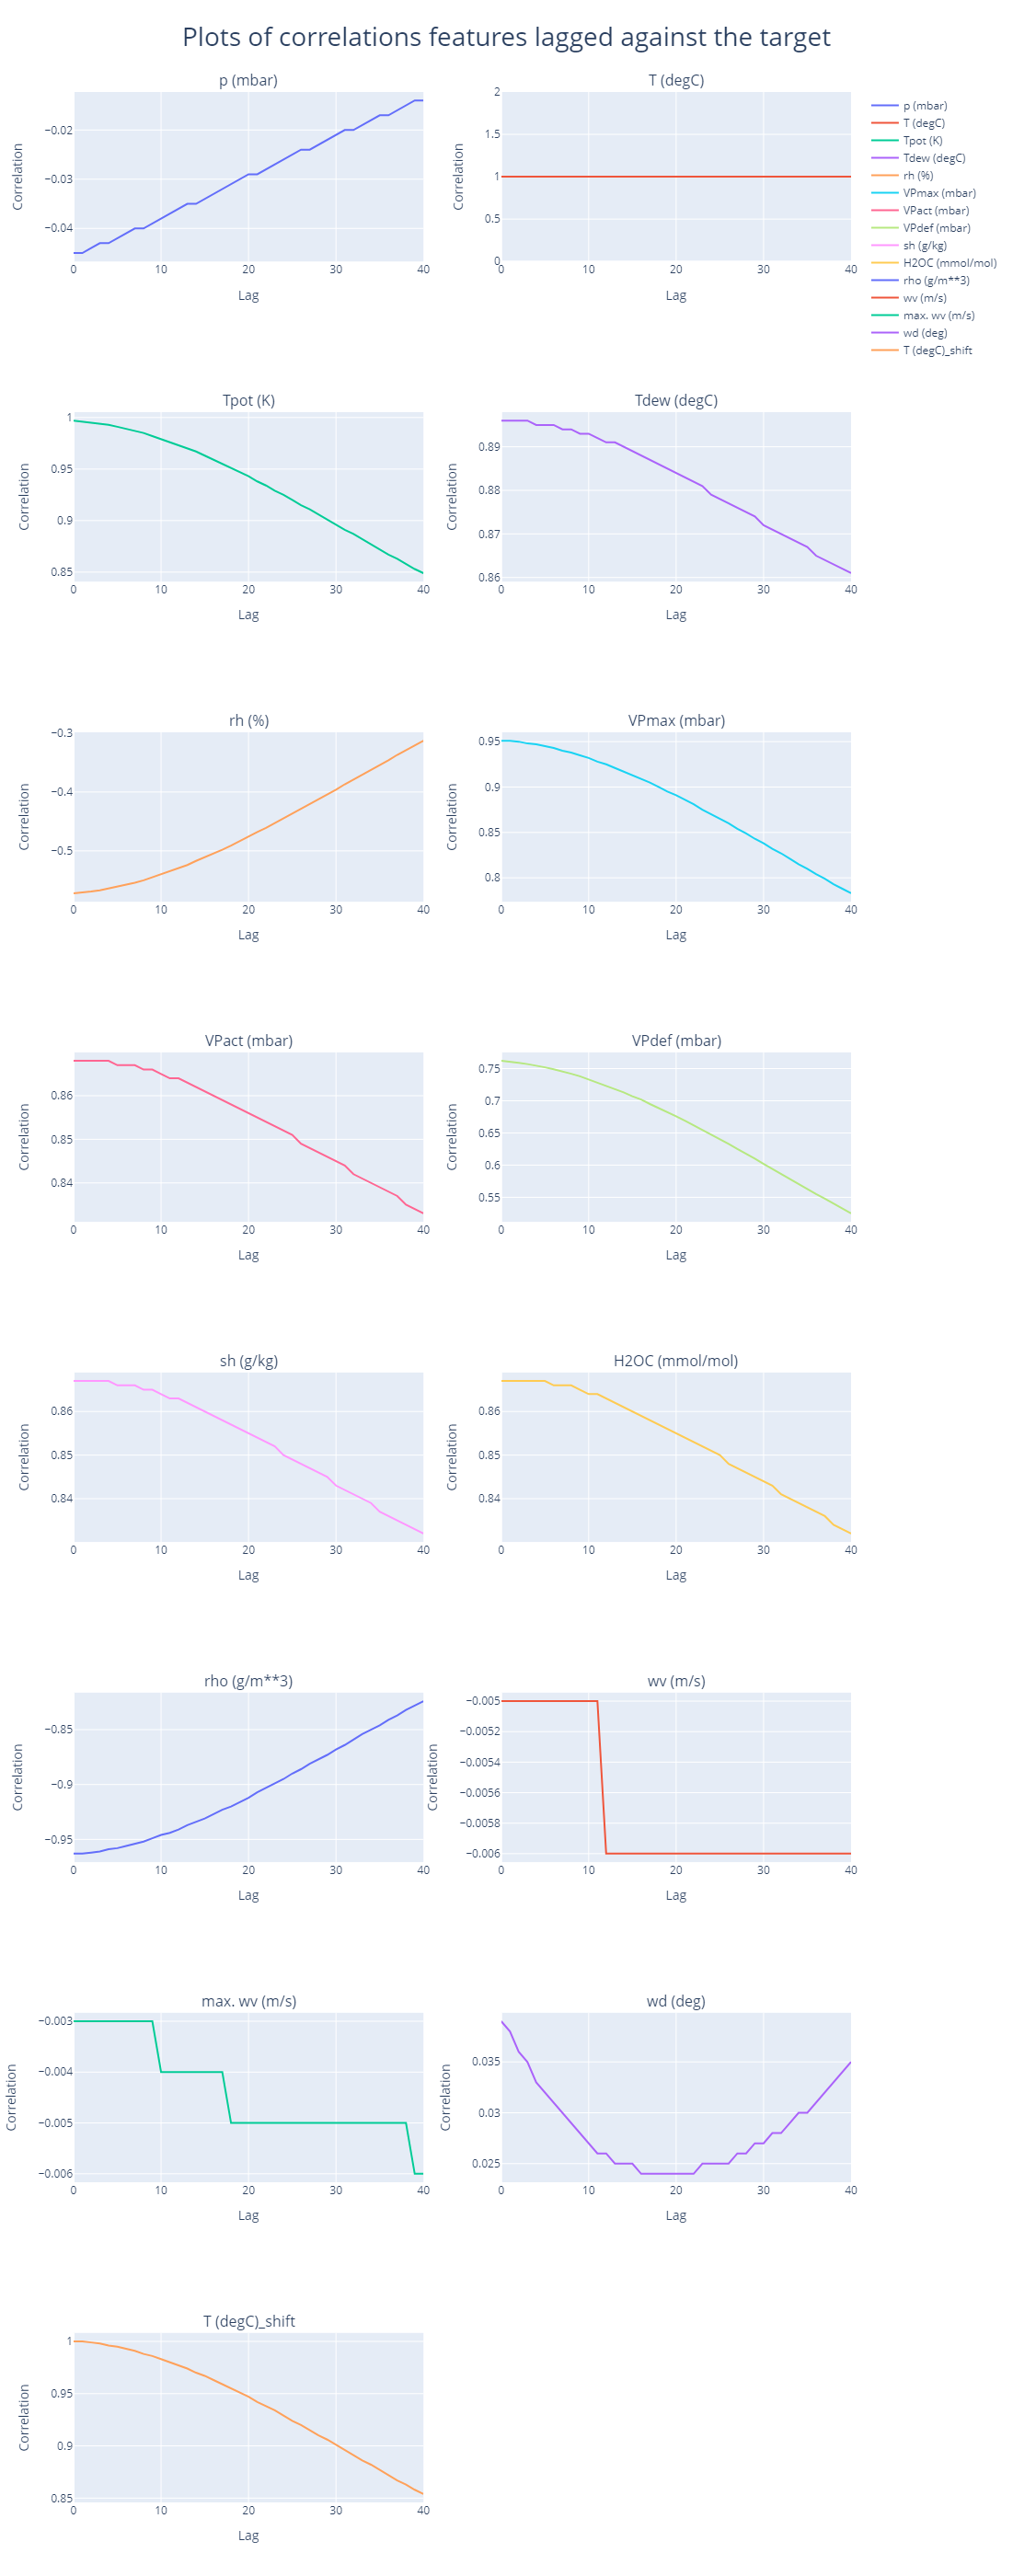

In [8]:
# calculate correlations each feature lagged againts the target
df_corr_features_lag_target = calculate_corr_features_lag_target(df = data, 
                                                                 target = 'T (degC)', 
                                                                 lags = 40
                                                                )

# plot correlations lagged
fig_corr_lag = plot_corr_features_lag_target(df_corr_lags = df_corr_features_lag_target)

# show
fig_corr_lag.show()

# save
fig_corr_lag.write_html("output_eda/3_bivariate_analysis/plot_corr_features_lag.html")
pio.write_image(fig_corr_lag, "output_eda/3_bivariate_analysis/plot_corr_features_lag.png")